In [2]:
library(quantmod)
library(forecast)
library(tseries)
library(rugarch)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [3]:
#preprocessing
getSymbols("SPY", src = "yahoo", from = "2010-01-01", to = Sys.Date())
spy_prices <- Cl(SPY)
log_prices <- log(spy_prices)
diff_log_prices <- diff(log_prices)#*100#to avoid optimizer issues
diff_log_prices <- na.omit(diff_log_prices)

[1] "SPY"

### Analisi esplorativa
Come prima cosa è opportuno plottare la serie temporale dei prezzi e il logaritmo dei prezzi. Inoltre è utile plottare la serie differenziata del logaritmo dei prezzi, su cui verificheremo l'ipotesi di stazionarietà debole. Come ultimo plot poi verificheremo l'aderenza della distribuzione dei prezzi logaritmici differenziati alla normale


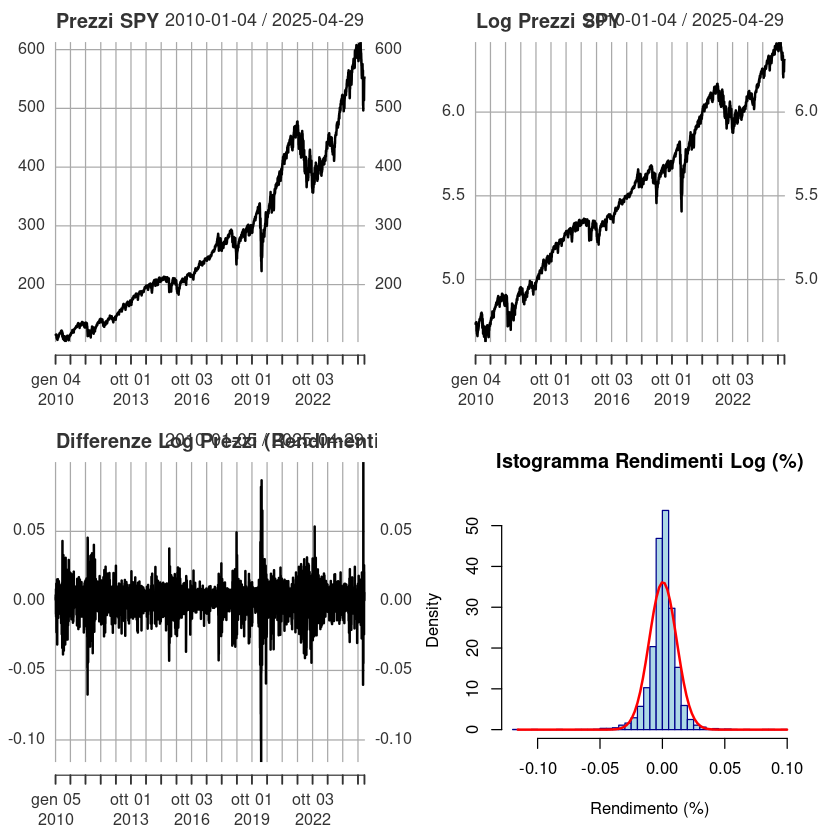

In [3]:
par(mfrow = c(2,2))
plot(spy_prices, main = "Prezzi SPY")
plot(log_prices, main = "Log Prezzi SPY")
plot(diff_log_prices, main = "Differenze Log Prezzi (Rendimenti, in %)")
diff_log_prices_num <- as.numeric(diff_log_prices)
hist(diff_log_prices_num, breaks = 50, probability = TRUE,
     main = "Istogramma Rendimenti Log (%)", 
     xlab = "Rendimento (%)", col = "lightblue", border = "darkblue")
x_vals <- seq(from = min(diff_log_prices_num), to = max(diff_log_prices_num), length.out = 100)
dens_vals <- dnorm(x_vals, mean = mean(diff_log_prices_num), sd = sd(diff_log_prices_num))
lines(x_vals, dens_vals, col = "red", lwd = 2)
par(mfrow = c(1,1))

### Verifica della stazionarietà (debole) della serie
Utilizzando l'Augmented Dickey-Fuller test, che suppone la non stazionarietà come ipotesi nulla possiamo capire se la serie è stazionaria in senso debole, condizione necessaria per l'applicazione di qualsiasi modello arima.

In [4]:
adf_result <- adf.test(diff_log_prices)
print(adf_result)

Warning message in adf.test(diff_log_prices):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_prices
Dickey-Fuller = -16.433, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



Come ci aspettavamo la serie è debolmente stazionaria. Questo permette di poter valutare un modello arima per stimare la parte di medie e valutarne la parte di residui. Come prima cosa andiamo a plottare ACF e PACF per i rendimenti differenziati, che possono suggerire informazioni sugli ordini di AR e MA.

#### ACF
Misura la correlazione tra una serie temporale e se stessa spostata di un lag. Indica quanto è forte la correlazione tra $X_t$ e $X_{t-k}$. Quando l'ACF si azzera, la correlazione si annulla e questo suggerisce l'ordine della componente MA del modello.

#### PACF
Misura la correlazione diretta tra la serie e le sue versioni ritardate al lag $k$, controllando l'effetto dei lag intermenti. Fornisce l'autocorrelazione tra $X_t$ e $X_{t-k}$ quando si tengono costanti i restanti valori. Questo è particolarmente utile per determinare l'ordine della componente AR in un modello arima.


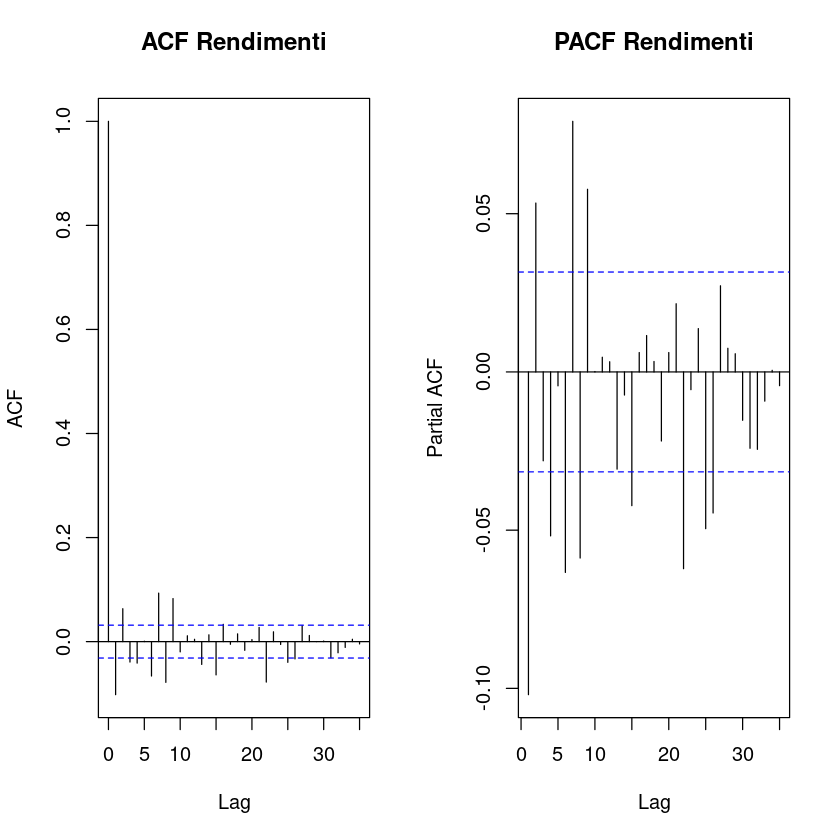

In [5]:
par(mfrow = c(1,2))
acf(diff_log_prices, main = "ACF Rendimenti")
pacf(diff_log_prices, main = "PACF Rendimenti")
par(mfrow = c(1,1))

Possiamo ora stimare i modelli ARIMA. Utilizzeremo per la ricerca modelli con $ p,q \leq 2$ per evitare overfitting e rendere l'interpretazione piu chiara. Questo ci permette di confrontare direttamente i modelli tramite criteri informativi come l'AIC, oltre ad ottenere una stima più stabile dei parametri.

In [7]:
#model named with 1 as integrating param due to preprocess
model_111 <- arima(diff_log_prices, order = c(1,0,1))
model_211 <- arima(diff_log_prices, order = c(2,0,1))
model_121 <- arima(diff_log_prices, order = c(1,0,2))
model_212 <- arima(diff_log_prices, order = c(2,0,2))
model_011 <- arima(diff_log_prices, order = c(0,0,1))
model_100 <- arima(diff_log_prices, order = c(1,0,0))
#aic index
cat("AIC modello ARIMA(1,1,1):", AIC(model_111), "\n")
cat("AIC modello ARIMA(2,1,1):", AIC(model_211), "\n")
cat("AIC modello ARIMA(1,1,2):", AIC(model_121), "\n")
cat("AIC modello ARIMA(2,1,2):", AIC(model_212), "\n")
cat("AIC modello ARIMA(0,1,1):", AIC(model_011), "\n")


AIC modello ARIMA(1,1,1): -23840.22 
AIC modello ARIMA(2,1,1): -23840.42 
AIC modello ARIMA(1,1,2): -23841.07 
AIC modello ARIMA(2,1,2): -23901.49 
AIC modello ARIMA(0,1,1): -23828.47 


Possiamo notare come il modello ARIMA(2,1,2) abbia AIC più basso e quindi sia il migliore per modellizzare la parte di media della nostra serie temporale. Siamo interessati ora a visualizzare i residui.

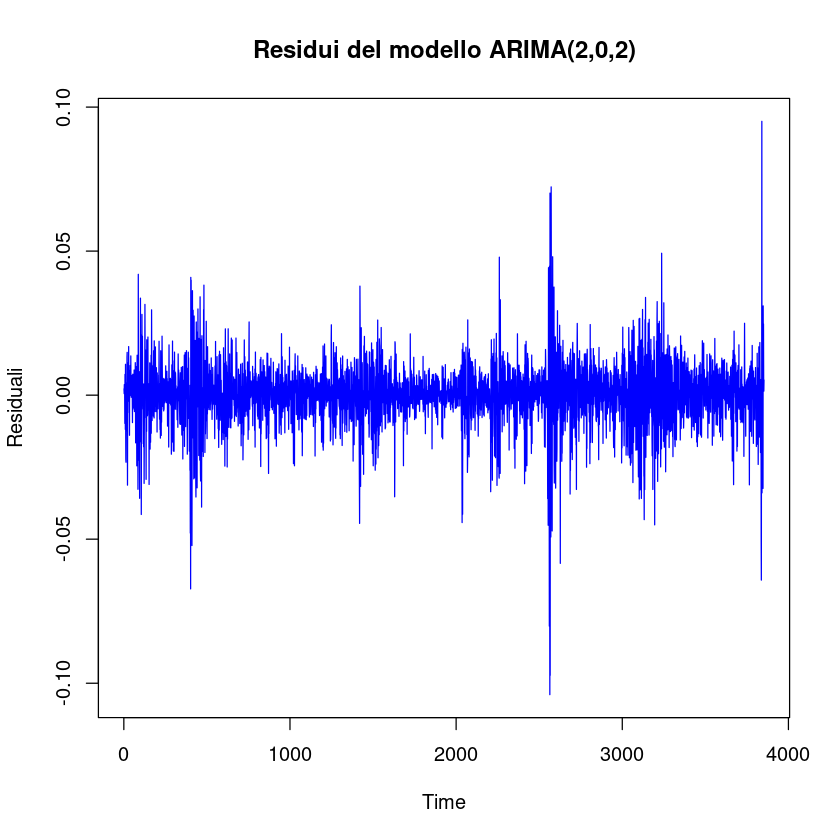

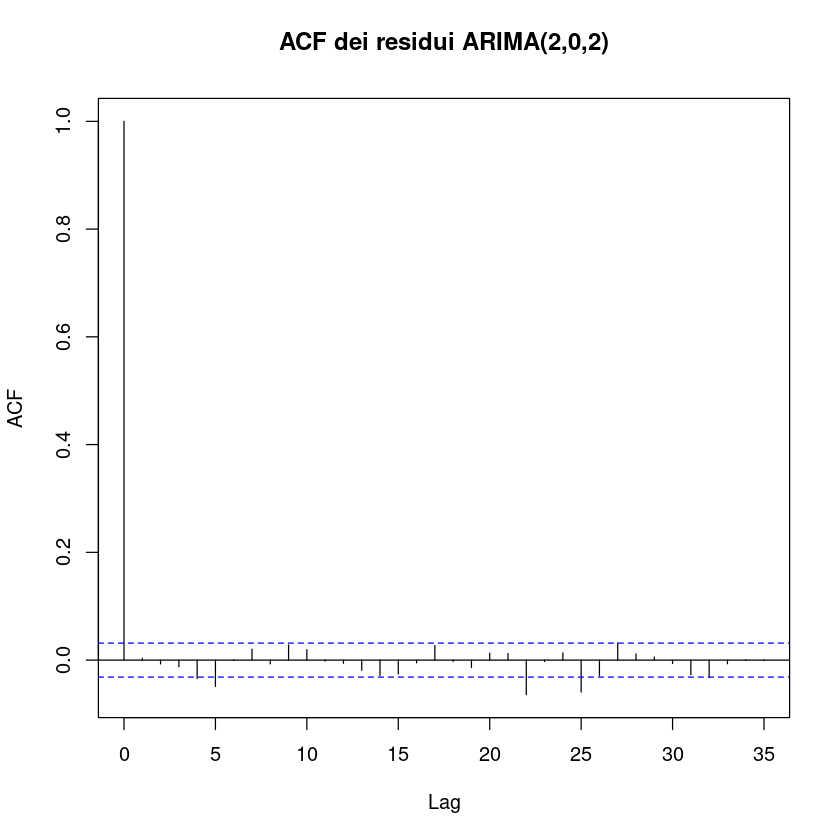

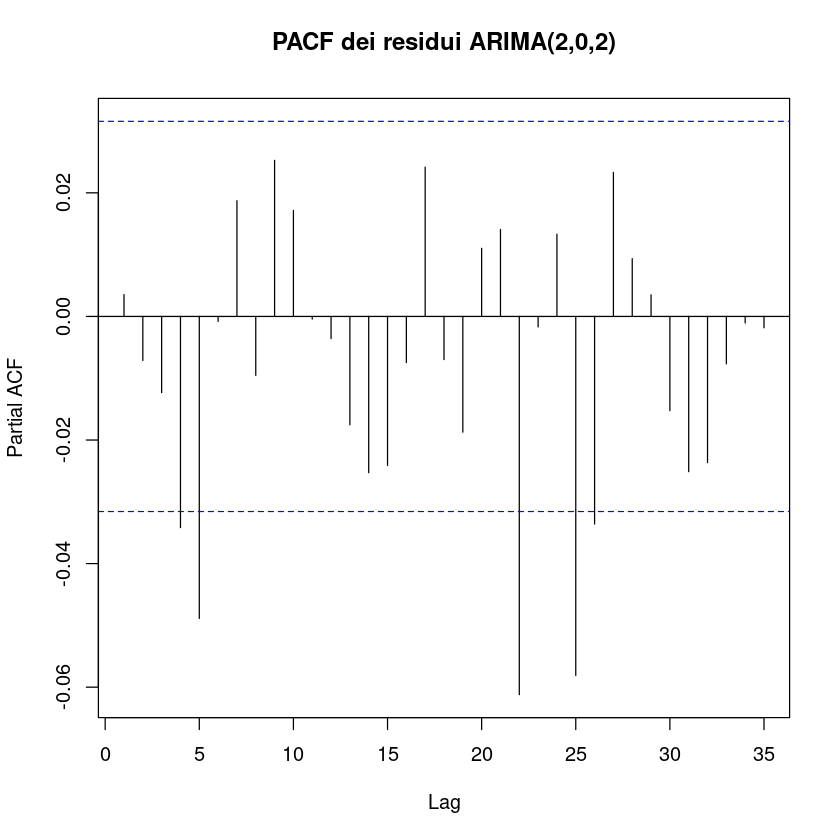

In [8]:
res_212 <- residuals(model_212)
#plot
plot(res_212, 
     main = "Residui del modello ARIMA(2,0,2)", 
     ylab = "Residuali", 
     col = "blue")
acf(res_212, 
    main = "ACF dei residui ARIMA(2,0,2)")   

pacf(res_212, 
     main = "PACF dei residui ARIMA(2,0,2)") 


### Autocorrelazione dei residui

Possiamo ora utilizzare il test Ljung-Box per verificare se i residui del modello mostrano autocorrelazioni significative fino ad un certo numero di lag. Il test confronta le autocorrelazioni osservate nei residui con quelle attese per una serie casuale. Questo permette di valutare eventuali effetti di clustering della volatilità per cui sarebbe ragionevole utilizzare un modello ARCH/GARCH.

In [12]:
#test on residuals
lb_test <- Box.test(res_212, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui:\n")
print(lb_test)
#test on square residuals for ARCH/GARCH
lb_test_sq <- Box.test(res_212^2, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui^2 (per effetti ARCH):\n")
print(lb_test_sq)

Ljung-Box test sui residui:

	Box-Ljung test

data:  res_212
X-squared = 32.357, df = 20, p-value = 0.03964

Ljung-Box test sui residui^2 (per effetti ARCH):

	Box-Ljung test

data:  res_212^2
X-squared = 3426.2, df = 20, p-value < 2.2e-16




I risultati mostrano come sia ancora presente autocorrelazione significativa. La parte del modedello ARIMA non ha catturato in maniera efficace l'autocorrelazione presente nella serie. Il test dei residui al quadrato serve per verificare la presenza di effetti ARCH, ovvero di clustering di volatilita'. Il p-value basso porta al rifiuto dell'ipotesi nulla e motiva la scelta di un modello GARCH.

In questo caso manteniamo ancora l'ARIMA come parte integrante del modello, passando al GARCH i residui del miglior ARIMA precedentemente stimato. Valuteremo poi l'efficacia di questo approccio successivamente con l'estrazione delle metriche.

In [13]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "norm"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
print(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per GARCH(1,1): ",aic, ".\n")


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000004    0.000001   2.5126 0.011985
alpha1  0.157979    0.012651  12.4871 0.000000
beta1   0.813533    0.015611  52.1141 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000004    0.000009  0.40819  0.68313
alpha1  0.157979    0.019450  8.12250  0.00000
beta1   0.813533    0.068374 11.89821  0.00000

LogLikelihood : 12725.42 

Information Criteria
------------------------------------
                    
Akaike       -6.6039
Bayes        -6.5990
Shibata      -6.6039
Hannan-Quinn -6.6022

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
           

Possiamo discutere i parametri stimati dal modello e le loro implicazioni teoriche. Il parametro omega che rappresenta il termine costante della varianza condizionale risulta significativo, indicando una varianza di lungo periodo positiva (e piccola). Il parametro alpha1 misura l'effetto degli shock passati sulla volatilita' condizionale ed ha un p-value estremamente basso. Questo indica che gli shock passati hanno un impatto significativo sulla volatilita' futura. Il parametro beta1 rappresenta la persistenza della volatilita' passata su quella futura. Anche questo valore e' altamente significativo, indicando un impatto forte della volatilita' passata su quella futura. Notiamo inoltre come sia il Ljung-Box test sui residui standardizzati ci porti a rifiutare l'ipotesi nulla, come discusso precedentemente. Tuttavia il test sui residui standardizzati al quadrato dimostra come il modello GARCH abbia efficacemente filtrato il clustering di volatilita'. Questo risultato viene confermato dall'ARCH LM test, che presenta p-value significativi ad ogni lag, ovvero non sono presenti effetti ARCH non catturati dal modello. Il test di stabilita' di Nyblom conferma una stima efficace dei parametri. Il Sign Bias Test suggerisce che, seppur non ci sia un bias positivo o negativo di segno nei rendimenti, il modello abbia un bias significativo complessivo nei segni dei residui. Il test di Goodness of Fit indica che il modello non si e' adattato bene ai dati, ovvero la distribuzione ipotizzata non cattura adeguatamente le caratteristiche dei dati. Questo e' imputabile a code pesanti o assimmetrie nei rendimenti, che andremo ora a verificare.


### QQ-plot
Vediamo ora un QQ-plot in cui confrontiamo quantili empirici con quelli teorici ipotizzati dalla distribuzione scelta (Normale)

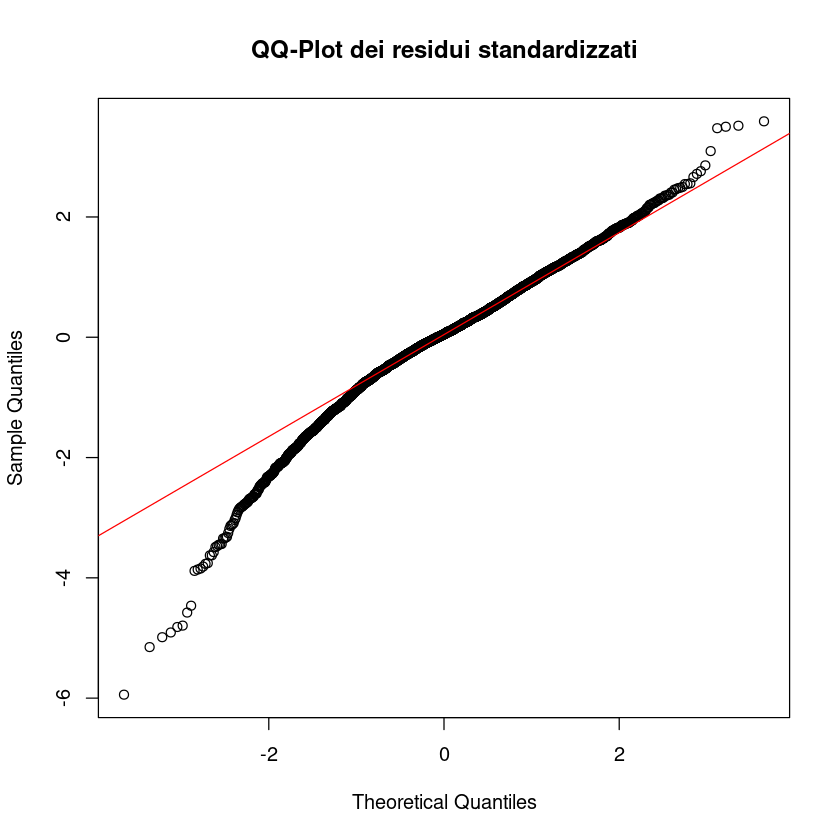

In [14]:
std_resid_normal <- residuals(garch_fit, standardize = TRUE)
qqnorm(std_resid_normal, main="QQ-Plot dei residui standardizzati")
qqline(std_resid_normal, col="red")


In [15]:
std_resid_normal <- coredata(std_resid_normal)
shapiro_test_result <- shapiro.test(std_resid_normal)
print(shapiro_test_result)


	Shapiro-Wilk normality test

data:  std_resid_normal
W = 0.97478, p-value < 2.2e-16



### Normalità dei residui standardizzati

I due test rifiutano l'ipotesi di normalità dei residui standardizzati. Infatti, il test di normalità di Shapiro-Wilk presenta un p-value molto basso e dobbiamo quindi rifiutare l'ipotesi nulla. Questo rifiuto viene corroborato dal test qualitativo del QQ-plot: notiamo infatti come la coda di sinistra si discosti significativamente dalla diagonale ideale della normale. Possiamo quindi dedurre che le code siano più pesanti e asimmetriche rispetto ad una distribuzione normale. Verifichiamo queste ipotesi andando a controllare la skewness e la kurtosis dei rendimenti logaritmici e dei residui standardizzati.

In [16]:
library(moments)
# number of observations for returns
n_ret <- length(diff_log_prices)
se_ret <- sqrt(6 / n_ret)

# skewness e z-score for returns
skew_ret <- skewness(diff_log_prices)
z_ret    <- skew_ret / se_ret
p_ret    <- 2 * pnorm(-abs(z_ret))

cat("Return skewness:", skew_ret, "\n")
cat("  z-score:", z_ret,   "\n")
cat("  p-value:", p_ret,   "\n\n")

# number of observations for residuals
std_resid_num <- as.numeric(std_resid_normal)
n_res <- length(std_resid_num)
se_res <- sqrt(6 / n_res)

# skewness e z-score for std residuals
skew_res <- skewness(std_resid_num)
z_res    <- skew_res / se_res
p_res    <- 2 * pnorm(-abs(z_res))

cat("Std. residuals skewness:", skew_res, "\n")
cat("  z-score:", z_res,       "\n")
cat("  p-value:", p_res,       "\n")

# kurtosis for returns
kurt_ret <- kurtosis(diff_log_prices)
cat("Kurtosis for returns:", kurt_ret, "\n")

# kurtosis for standardized residuals
kurt_res <- kurtosis(std_resid_num)
cat("Kurtosis for standardized residuals:", kurt_res, "\n")



Return skewness: -0.5562028 
  z-score: -14.09474 
  p-value: 4.091601e-45 

Std. residuals skewness: -0.6388801 
  z-score: -16.18987 
  p-value: 5.945772e-59 
Kurtosis for returns: 15.18557 
Kurtosis for standardized residuals: 4.882245 


Notiamo quindi che sia i rendimenti logaritmici che i residui standardizzati presentano asimmetrie negative, tipiche degli andamenti finanziari. La distribuzione dei rendimenti (e conseguentemente dei residui) ha una coda a sinistra più pesante, ovvero occasionalmente ci sono rendimenti negativi più estremi rispetto alla media. Questa ipotesi è corroborata dallo z-score negativo che indica che la skewness osservata e' molto lontana dallo zero ed un p-value basso. Il modello dovrebbe quindi considerare una distribuzione asimmetrica (skewed t). Inoltre la kurtosis indica la presenza di code particolarmente pesanti.



### t di Student
Inizialmente possiamo ipotizzare una t di Student come distribuzione per le volatilità condizionate nel modello GARCH, che dovrebbe mitigare almeno in parte il problema delle code pesanti. Andremo poi a valutare l'impatto di una skewed-t come distribuzione per il GARCH.

In [17]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "std"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
print(garch_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000002    0.000001   1.7264 0.084275
alpha1  0.157590    0.023236   6.7823 0.000000
beta1   0.834552    0.021460  38.8890 0.000000
shape   5.879567    0.596631   9.8546 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000002    0.000005  0.42538 0.670559
alpha1  0.157590    0.072292  2.17991 0.029264
beta1   0.834552    0.072836 11.45788 0.000000
shape   5.879567    1.008159  5.83199 0.000000

LogLikelihood : 12826.14 

Information Criteria
------------------------------------
                    
Akaike       -6.6557
Bayes        -6.6492
Shibata      -6.6557
Hannan-Quinn -6.6534

Weigh

Possiamo notare da questo modello come tutti i parametri stimati siano significativi. Resta il problema sui residui che presentano ancora correlazione seriale. Le precedenti considerazioni restano vere per i restanti test. Andiamo a controllare il QQ-plot per vedere se la scelta di una t di Student abbia mitigato le discrepanze nella coda di sinistra.

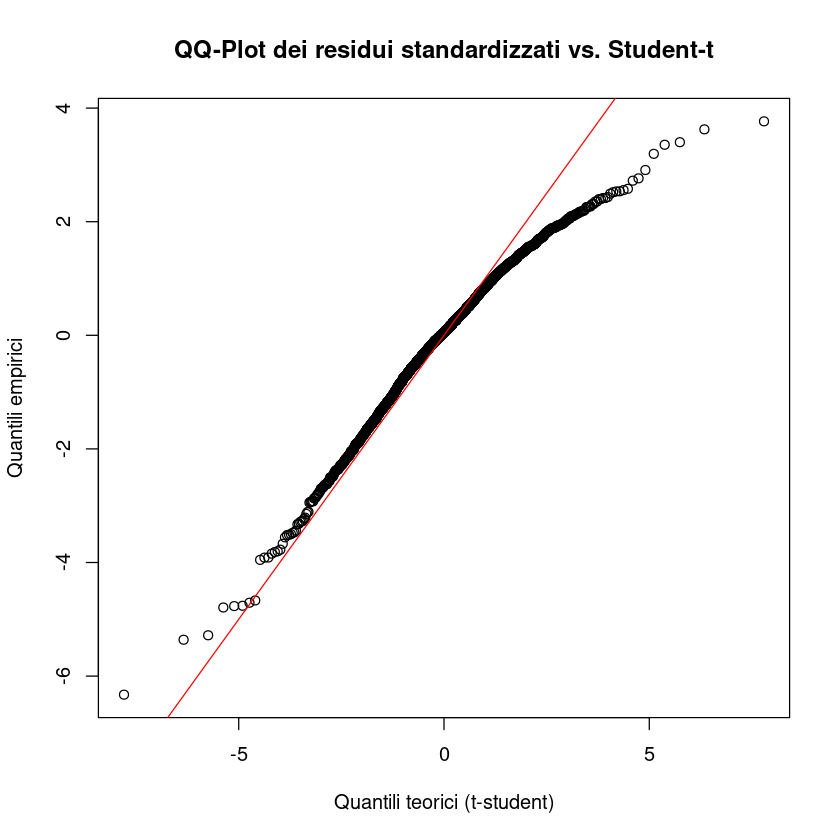

In [19]:
std_resid_t <- residuals(garch_fit, standardize = TRUE)
std_resid_t <- as.numeric(coredata(std_resid_t))
#freedom degrees
df <- as.numeric(garch_fit@fit$coef[["shape"]])
#theorical distribution
theo_q <- qt(ppoints(length(std_resid_t)),df = df)
qqplot(theo_q, std_resid_t, 
       main = "QQ-Plot dei residui standardizzati vs. Student-t",
       xlab = "Quantili teorici (t-student)",
       ylab = "Quantili empirici")
abline(0, 1, col = "red")

### Migliore fit rispetto alla normale

Nel nuovo QQ-plot notiamo che i residui aderiscono meglio alla diagonale dei quantili teorica. Le deviazioni risultano attenuate rispetto al QQ-plot della normale, suggerendo una modellizzazione più efficace delle caratteristiche della serie.

### Skewed t
Ora vogliamo verificare l'effetto di una t di Student assimetrica (abbiamo precedentemente dimostrato che l'assimetria moderata è statisticamente significativa) sul modello e sul QQ-plot.
 

In [24]:
#sstd
spec_garch_sstd <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "sstd"
)
garch_fit_sstd <- ugarchfit(spec = spec_garch_sstd, data = as.numeric(diff_log_prices))
print(garch_fit_sstd)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000751    0.000079      9.4880  0.00000
ar1    -0.160853    0.010274    -15.6559  0.00000
ar2     0.799325    0.010154     78.7234  0.00000
ma1     0.098294    0.000591    166.2514  0.00000
ma2    -0.867327    0.000033 -26028.3125  0.00000
omega   0.000002    0.000001      1.4807  0.13868
alpha1  0.141938    0.024557      5.7798  0.00000
beta1   0.844653    0.023858     35.4029  0.00000
skew    0.826385    0.023602     35.0128  0.00000
shape   6.401291    0.734450      8.7158  0.00000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000751    0.000111  6.7725e+00 0.000000
ar1    -0.160853

I parametri stimati sono tutti significativi (tolto omega, parte fissa della varianza). La scelta della t-skewed e' quindi efficace, come mostrato dalla significativita' del parametro skew. Resta il problema della correlazione lineare, mentre sono migliorati i valori del p-value del Goodness-of-Fit test suggerendo una migliore aderenza del modello ai dati.

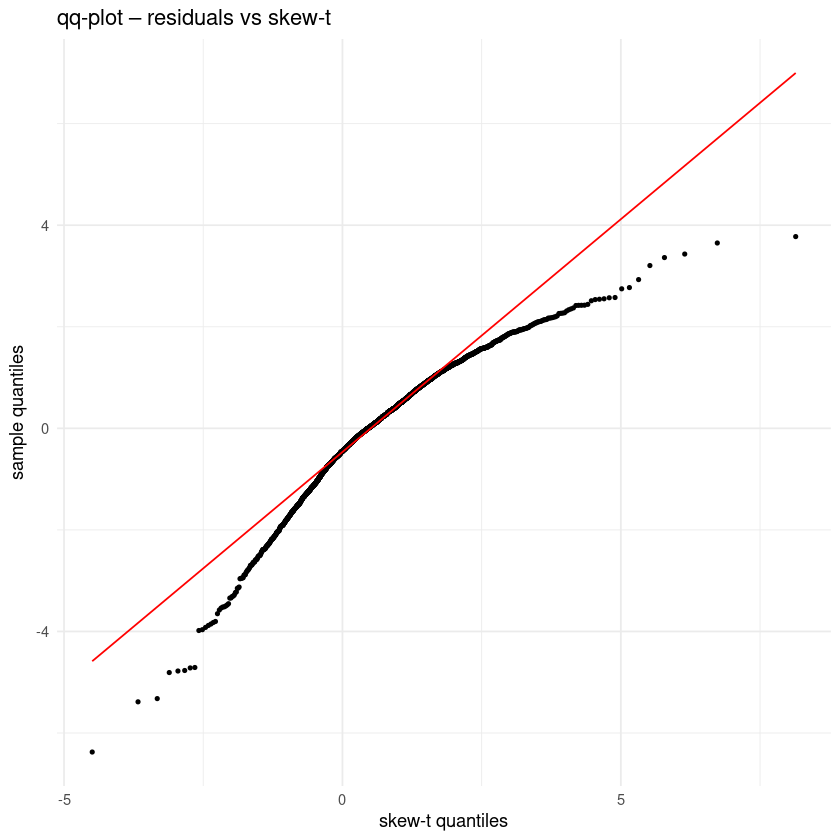

In [38]:

library(sn)        # skew-t utils
library(ggplot2)

# pull model params
sk  <- coef(garch_fit_sstd)["skew"]
nu  <- coef(garch_fit_sstd)["shape"]      # df
res <- residuals(garch_fit_sstd, standardize = TRUE)

# theoretical quantiles from skew-t
th <- qst(ppoints(length(res)), xi = 0, omega = 1, alpha = sk, nu = nu)

# qq plot
ggplot(data.frame(theo = th, samp = res), aes(sample = samp)) +
  stat_qq(distribution = qst, dparams = list(xi = 0, omega = 1, alpha = sk, nu = nu),
          size = .8) +
  stat_qq_line(distribution = qst, dparams = list(xi = 0, omega = 1, alpha = sk, nu = nu),
               colour = "red") +
  labs(title = "qq-plot – residuals vs skew-t",
       x = "skew-t quantiles", y = "sample quantiles") +
  theme_minimal()


Il QQ-plot risulta qualitativamente peggiore rispetto al caso della t di Student normale. Questo puo' essere dovuto al fatto che, nonostante la skewness sia significativa, questo non garantisce che la distribuzione asimmetrica outperformi la normale t di Student. Al fine di capire quale delle due distribuzioni performi meglio utilizzeremo successivamente delle metriche di previsione.

### Modelli GARCH: eGARCH, GJR-GARCH, e sGARCH

#### 1. **sGARCH (Standard GARCH)**

Il **modello sGARCH** è il più semplice tra i modelli GARCH ed è definito come segue:

$$
y_t = \mu + \epsilon_t
$$
$$
\epsilon_t = \sigma_t \cdot z_t
$$
$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

Dove:
- $ \omega $ è un parametro costante.
- $ \alpha_1 $ rappresenta l'effetto degli **shock passati** sulla volatilità attuale.
- $ \beta_1 $ rappresenta l'effetto della **volatilità passata** sulla volatilità attuale.
- $ z_t $ è un processo di rumore bianco con media zero e varianza unitaria.

**Caratteristiche**:
- Il modello sGARCH è adatto per dati con **volatilità persistente**.
- Non modella gli **shock asimmetrici** (ossia, assume che gli shock positivi e negativi influenzino la volatilità allo stesso modo).

#### 2. **GJR-GARCH**

Il **modello GJR-GARCH** è una variante del modello sGARCH che permette di modellare l'**asimmetria** nella risposta della volatilità agli shock. Il modello è definito come:

$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2 + \gamma_1 \cdot I(\epsilon_{t-1} < 0) \cdot \epsilon_{t-1}^2
$$

Dove:
- $ I(\epsilon_{t-1} < 0) $ è una variabile indicatrice che assume valore 1 quando lo shock passato è negativo e 0 altrimenti.
- $ \gamma_1 $ cattura l'effetto **asimmetrico**: un valore positivo di $ \gamma_1 $ implica che gli **shock negativi** aumentano la volatilità più degli **shock positivi**.

**Caratteristiche**:
- Modella gli **shock asimmetrici**, cioè ovvero l'idea che shock negativi abbiano un'influenza maggiore rispetto a quelli positivi.

#### 3. **eGARCH (Exponential GARCH)**

Il **modello eGARCH** è una variante più avanzata del GARCH che può modellare sia l'**asimmetria** che l'**esplosività** della volatilità. È definito come:

$$
\log(\sigma_t^2) = \omega + \alpha_1 \left( \frac{\epsilon_{t-1}}{\sigma_{t-1}} \right) + \beta_1 \log(\sigma_{t-1}^2)
$$

Dove:
- $ \alpha_1 $ rappresenta l'effetto degli **shock passati**, ma questa volta normalizzati per la volatilità.
- $ \beta_1 $ modella l'effetto della **volatilità passata**.
- $ \log(\sigma_t^2) $ modella la **volatilità che cresce esponenzialmente** nel tempo.

**Caratteristiche**:
- È particolarmente utile quando la volatilità mostra comportamenti **asimmetrici** (più forte risposta a shock negativi) e **non lineari**.
- Poiché la volatilità è modellata tramite il logaritmo della varianza, è possibile evitare **problemi di esplosività** che potrebbero verificarsi in altri modelli GARCH.
- È in grado di catturare una **risposta più fluida** agli shock e una volatilità **più reattiva** ai cambiamenti nei dati.


Andremo quindi a valutare quale di questi modelli si adatti meglio ai nostri dati.

In [23]:
# egarch with skewed t
spec_eGARCH <- ugarchspec(
  variance.model = list(model = "eGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "sstd"
)

egarch_fit <- ugarchfit(spec = spec_eGARCH, data = as.numeric(diff_log_prices))

print(egarch_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(2,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000396    0.000097   4.0836  4.4e-05
ar1    -0.393269    0.022147 -17.7572  0.0e+00
ar2     0.428990    0.075066   5.7148  0.0e+00
ma1     0.348053    0.021654  16.0731  0.0e+00
ma2    -0.475277    0.074681  -6.3641  0.0e+00
omega  -0.345383    0.015612 -22.1223  0.0e+00
alpha1 -0.177446    0.012879 -13.7780  0.0e+00
beta1   0.963560    0.001667 578.1118  0.0e+00
gamma1  0.183263    0.021572   8.4953  0.0e+00
skew    0.822394    0.019671  41.8077  0.0e+00
shape   6.768288    0.763863   8.8606  0.0e+00

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000396    0.000097   4.0785  4.5e-05
ar1    -

Il parametro mu di media risulta significativo ed un p-value molto basso, indicando come la media dei rendimenti sia significativamente diversa da zero. I parametri autoregressivi e di media mobile significativi indicano la prensenza di dipendenza temporale nei rendimenti. I parametri di volatilita' sono anch'essi significativi, in particolare il parametro gamma1 che rappresenta l'effetto leverage, indicando che la volatilita' tende ad aumentare di piu' in risposta a shock negativi rispetto a positivi. La skewness e' positiva, risultato che non e' particolarmente convincente rispetto a cio' che avevamo ottenuto precedentemente, mentre il parametro di shape indica la presenza di code pesanti. Il test di Ljung-Box indica che per i lag testati non ci sono correlazioni seriali significative nei residui, suggerendo che il modello ha catturato adeguatamente la dipendenza temporale. Anche gli effetti ARCH sono stati correttamente modellati. Il test di Sign Bias mostra un t-value significativo per il Sign Bias indicando che potrebbero esserci effetti sistematici nei rendimenti legati alla direzione della variazione.

In [25]:
# gjr garch with skewed t
spec_gjr <- ugarchspec(
  variance.model = list(model = "gjrGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "sstd"
)

gjr_fit <- ugarchfit(spec = spec_gjr, data = as.numeric(diff_log_prices))

print(gjr_fit)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(2,0,2)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000485    0.000097  4.9979e+00 0.000001
ar1    -0.351091    0.014725 -2.3843e+01 0.000000
ar2     0.613997    0.013125  4.6780e+01 0.000000
ma1     0.307757    0.001305  2.3586e+02 0.000000
ma2    -0.661457    0.000149 -4.4301e+03 0.000000
omega   0.000003    0.000000  5.6736e+00 0.000000
alpha1  0.000080    0.002510  3.2007e-02 0.974466
beta1   0.848893    0.010481  8.0997e+01 0.000000
gamma1  0.251167    0.021389  1.1743e+01 0.000000
skew    0.830566    0.019932  4.1671e+01 0.000000
shape   6.535189    0.666770  9.8013e+00 0.000000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.0004

Le considerazioni fatte sui parametri precedenti restano valide, mentre i nuovi parametri utilizzati dal gjr sono significativi. Tuttavia il test di stabilita' suggerisce un problema nella stima dei parametri, in quanto la statistica congiunta del test supera il valore critico e quindi l'ipotesi nulla di stabilita' dei parametri puo' essere rifiutata.

Ora valuteremo l'efficacia di un forecast univariato e calcoleremo RMSE/MAE e coverage dei 95% bands per validare il modello out-of-sample. L'idea è quella di utilizzare un approccio rolling-window per valutare queste metriche.

In [ ]:


# data
y <- as.numeric(diff_log_prices)
window_size <- 750
n_total <- length(y)
n_ahead <- 1
n_roll <- n_total - (window_size + n_ahead)


# forecasting containers
f_ret   <- matrix(NA, n_roll, 3)  # one column for each model
f_sigma <- matrix(NA, n_roll, 3)  # one column for each model
a_ret   <- rep(NA, n_roll)
a_sigma <- rep(NA, n_roll)

errors <- integer(0)

# define the garch model specifications
spec_sGARCH <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "sstd"
)

spec_eGARCH <- ugarchspec(
  variance.model = list(model = "eGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "sstd"
)

spec_gjrGARCH <- ugarchspec(
  variance.model = list(model = "gjrGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "sstd"
)
pb <- txtProgressBar(min = 0, max = n_roll, style = 3)

# function to evaluate a model with both skewed t and t distribution
for (i in seq_len(n_roll)) {
  # train window and try-catch for errors
  train_idx <- i:(i + window_size - n_ahead)
  success <- tryCatch({
    withCallingHandlers({
      # fit models for sGARCH
      fit_sGARCH <- ugarchfit(spec = spec_sGARCH, data = y[train_idx], solver = "hybrid", silent = TRUE)
    }, warning = function(w) stop(w))
    TRUE}, error = function(e) {
      # handle errors
      errors <<- c(errors, i)
      FALSE
    })
    if (success) {
      # forecast for sGARCH
      fc_sGARCH <- ugarchforecast(fit_sGARCH, n.ahead = n_ahead)
        # save forecasts and actuals for each model
      f_ret[i, 1]   <- as.numeric(fc_sGARCH@forecast$seriesFor)
      f_sigma[i, 1] <- as.numeric(fc_sGARCH@forecast$sigmaFor)
    }
  success <- tryCatch({
    withCallingHandlers({
      # fit models for eGARCH
      fit_eGARCH <- ugarchfit(spec = spec_eGARCH, data = y[train_idx], solver = "hybrid", silent = TRUE)
    }, warning = function(w) stop(w))
    TRUE}, error = function(e) {
      # handle errors
      errors <<- c(errors, i)
      FALSE
    })
    if (success) {
      # forecast for eGARCH
      fc_eGARCH <- ugarchforecast(fit_eGARCH, n.ahead = n_ahead)
        # save forecasts and actuals for each model
      f_ret[i, 2]   <- as.numeric(fc_eGARCH@forecast$seriesFor)
      f_sigma[i, 2] <- as.numeric(fc_eGARCH@forecast$sigmaFor)
    }
  success <- tryCatch({
    withCallingHandlers({
      # fit models for sGARCH
      fit_gjrGARCH <- ugarchfit(spec = spec_gjrGARCH, data = y[train_idx], solver = "hybrid", silent = TRUE)
    }, warning = function(w) stop(w))
    TRUE}, error = function(e) {
      # handle errors
      errors <<- c(errors, i)
      FALSE
    })
    if (success) {
      # forecast for gjrGARCH
      fc_gjrGARCH <- ugarchforecast(fit_gjrGARCH, n.ahead = n_ahead)
        # save forecasts and actuals for each model
      f_ret[i, 3]   <- as.numeric(fc_gjrGARCH@forecast$seriesFor)
      f_sigma[i, 3] <- as.numeric(fc_gjrGARCH@forecast$sigmaFor)
    }
    a_ret[i]   <- y[i + window_size]
    a_sigma[i] <- abs(y[i + window_size]) #proxy
    setTxtProgressBar(pb, i)
}
close(pb)

# performance metrics
rmse_ret   <- apply(f_ret, 2, function(x) sqrt(mean((x - a_ret)^2, na.rm = TRUE)))
mae_ret    <- apply(f_ret, 2, function(x) mean(abs(x - a_ret), na.rm = TRUE))
mae_ret    <- apply(f_ret, 2, function(x) mean(abs(x - a_ret), na.rm = TRUE))
rmse_vol   <- apply(f_sigma, 2, function(x) sqrt(mean((x - a_sigma)^2, na.rm = TRUE)))
mae_vol    <- apply(f_sigma, 2, function(x) mean(abs(x - a_sigma), na.rm = TRUE))

# print results
cat("rolling‑window performance:\n")
for (j in 1:3) {
  cat(sprintf("model %d (rmse for returns): %.6f, mae for returns: %.6f\n", j, rmse_ret[j], mae_ret[j]))
  cat(sprintf("model %d (rmse for volatility): %.6f, mae for volatility: %.6f\n", j, rmse_vol[j], mae_vol[j]))
}


Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mea

rolling‑window performance:
model 1 (rmse for returns): 0.010898, mae for returns: 0.007132
model 1 (rmse for volatility): 0.007566, mae for volatility: 0.005513
model 2 (rmse for returns): 0.010907, mae for returns: 0.007158
model 2 (rmse for volatility): 0.007250, mae for volatility: 0.005216
model 3 (rmse for returns): 0.010831, mae for returns: 0.007150
model 3 (rmse for volatility): 0.007379, mae for volatility: 0.005252


I modelli sembrano avere, in termini di errori previsionali, performance equivalenti. Per la previsione dei ritorni notiamo come tutti e tre abbiano dei valori equivalenti, mentre il modello eGARCH mostra una leggera superiorita' nella previsione della volatilita'. E' inoltre utile notare come la differenza di previsione in media sia praticamente equivalente alla deviazione standard in-sample. Questo significa che il modello ARMA non riesce a prevedere un forecast particolarmente piu' efficace di un naive 0. Tuttavia, la stima dei parametri ARMA su queste finestre temporali non sempre risulta efficace, portando a warning ed errori gestiti tramite TryCatch. La conseguenza e' che alcune finestre di training vengono scartate perche la componente di previsione in media non riesce a convergere, motivo per cui d'ora in avanti ci concentreremo solo sulla componente di varianza. Prima di fare cio valutiamo come impatta la scelta di una t di Student normale sulle metriche di previsione.

In [4]:
# in-sample volatility
in_sample_sd <- sd(diff_log_prices, na.rm = TRUE)
cat("Deviazione standard (sample):", in_sample_sd, "\n")


Deviazione standard (sample): 0.01102926 


In [6]:


# data
y <- as.numeric(diff_log_prices)
window_size <- 750
n_total <- length(y)
n_ahead <- 1
n_roll <- n_total - (window_size + n_ahead)


# forecasting containers
f_ret   <- matrix(NA, n_roll, 3)  # one column for each model
f_sigma <- matrix(NA, n_roll, 3)  # one column for each model
a_ret   <- rep(NA, n_roll)
a_sigma <- rep(NA, n_roll)

errors <- integer(0)

# define the garch model specifications
spec_sGARCH <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "std"
)

spec_eGARCH <- ugarchspec(
  variance.model = list(model = "eGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "std"
)

spec_gjrGARCH <- ugarchspec(
  variance.model = list(model = "gjrGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(2,2), include.mean = TRUE),
  distribution.model = "std"
)
pb <- txtProgressBar(min = 0, max = n_roll, style = 3)

# function to evaluate a model with both skewed t and t distribution
for (i in seq_len(n_roll)) {
  # train window and try-catch for errors
  train_idx <- i:(i + window_size - n_ahead)
  success <- tryCatch({
    withCallingHandlers({
      # fit models for sGARCH
      fit_sGARCH <- ugarchfit(spec = spec_sGARCH, data = y[train_idx], solver = "hybrid", silent = TRUE)
    }, warning = function(w) stop(w))
    TRUE}, error = function(e) {
      # handle errors
      errors <<- c(errors, i)
      FALSE
    })
    if (success) {
      # forecast for sGARCH
      fc_sGARCH <- ugarchforecast(fit_sGARCH, n.ahead = n_ahead)
        # save forecasts and actuals for each model
      f_ret[i, 1]   <- as.numeric(fc_sGARCH@forecast$seriesFor)
      f_sigma[i, 1] <- as.numeric(fc_sGARCH@forecast$sigmaFor)
    }
  success <- tryCatch({
    withCallingHandlers({
      # fit models for eGARCH
      fit_eGARCH <- ugarchfit(spec = spec_eGARCH, data = y[train_idx], solver = "hybrid", silent = TRUE)
    }, warning = function(w) stop(w))
    TRUE}, error = function(e) {
      # handle errors
      errors <<- c(errors, i)
      FALSE
    })
    if (success) {
      # forecast for eGARCH
      fc_eGARCH <- ugarchforecast(fit_eGARCH, n.ahead = n_ahead)
        # save forecasts and actuals for each model
      f_ret[i, 2]   <- as.numeric(fc_eGARCH@forecast$seriesFor)
      f_sigma[i, 2] <- as.numeric(fc_eGARCH@forecast$sigmaFor)
    }
  success <- tryCatch({
    withCallingHandlers({
      # fit models for sGARCH
      fit_gjrGARCH <- ugarchfit(spec = spec_gjrGARCH, data = y[train_idx], solver = "hybrid", silent = TRUE)
    }, warning = function(w) stop(w))
    TRUE}, error = function(e) {
      # handle errors
      errors <<- c(errors, i)
      FALSE
    })
    if (success) {
      # forecast for gjrGARCH
      fc_gjrGARCH <- ugarchforecast(fit_gjrGARCH, n.ahead = n_ahead)
        # save forecasts and actuals for each model
      f_ret[i, 3]   <- as.numeric(fc_gjrGARCH@forecast$seriesFor)
      f_sigma[i, 3] <- as.numeric(fc_gjrGARCH@forecast$sigmaFor)
    }
    a_ret[i]   <- y[i + window_size]
    a_sigma[i] <- abs(y[i + window_size]) #proxy
    setTxtProgressBar(pb, i)
}
close(pb)

# performance metrics
rmse_ret   <- apply(f_ret, 2, function(x) sqrt(mean((x - a_ret)^2, na.rm = TRUE)))
mae_ret    <- apply(f_ret, 2, function(x) mean(abs(x - a_ret), na.rm = TRUE))
mae_ret    <- apply(f_ret, 2, function(x) mean(abs(x - a_ret), na.rm = TRUE))
rmse_vol   <- apply(f_sigma, 2, function(x) sqrt(mean((x - a_sigma)^2, na.rm = TRUE)))
mae_vol    <- apply(f_sigma, 2, function(x) mean(abs(x - a_sigma), na.rm = TRUE))

# print results
cat("rolling‑window performance:\n")
for (j in 1:3) {
  cat(sprintf("model %d (rmse for returns): %.6f, mae for returns: %.6f\n", j, rmse_ret[j], mae_ret[j]))
  cat(sprintf("model %d (rmse for volatility): %.6f, mae for volatility: %.6f\n", j, rmse_vol[j], mae_vol[j]))
}


  |==                                                                    |   2%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==                                                                    |   3%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==                                                                    |   4%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===                                                                   |   4%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===                                                                   |   5%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |====                                                                  |   6%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=======                                                               |  10%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |========                                                              |  11%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |========                                                              |  12%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==========                                                            |  14%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===========                                                           |  16%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=============                                                         |  19%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==============                                                        |  20%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=================                                                     |  24%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=================                                                     |  25%

Warning message in .makefitmodel(garchmodel = "eGARCH", f = .egarchLLH, T = T, m = m, :
“
rugarch-->warning: failed to invert hessian
”


  |==================                                                    |  25%

Warning message in .makefitmodel(garchmodel = "eGARCH", f = .egarchLLH, T = T, m = m, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "eGARCH", f = .egarchLLH, T = T, m = m, :
“
rugarch-->warning: failed to invert hessian
”


  |==================                                                    |  26%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in .makefitmodel(garchmodel = "eGARCH", f = .egarchLLH, T = T, m = m, :
“
rugarch-->warning: failed to invert hessian
”


  |====================                                                  |  28%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”


  |====================                                                  |  29%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=====================                                                 |  29%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=====================                                                 |  30%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |========================                                              |  34%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=========================                                             |  36%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===========================                                           |  39%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |============================                                          |  39%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |============================                                          |  40%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=============================                                         |  41%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==============================                                        |  43%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==================================                                    |  49%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |====================================                                  |  51%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=====================================                                 |  53%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |====================================================                  |  75%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=====================================================                 |  75%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=====================================================                 |  76%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |======================================================                |  77%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mea

  |=======================================================               |  78%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=======================================================               |  79%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |========================================================              |  79%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |========================================================              |  80%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mea

  |========================================================              |  81%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |=========================================================             |  82%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===========================================================           |  84%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |============================================================          |  86%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mea

  |=============================================================         |  87%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mea

  |=============================================================         |  88%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===============================================================       |  90%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |================================================================      |  91%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |==================================================================    |  95%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===================================================================   |  95%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===================================================================   |  96%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”


  |====================================================================  |  98%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |===================================================================== |  99%

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”
Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


  |======================================================================| 100%
rolling‑window performance:
model 1 (rmse for returns): 0.010898, mae for returns: 0.007132
model 1 (rmse for volatility): 0.007539, mae for volatility: 0.005481
model 2 (rmse for returns): 0.010887, mae for returns: 0.007164
model 2 (rmse for volatility): 0.007272, mae for volatility: 0.005214
model 3 (rmse for returns): 0.010892, mae for returns: 0.007154
model 3 (rmse for volatility): 0.007616, mae for volatility: 0.005348


Anche qui sul piano delle medie non notiamo differenze in termini di performance previsionali significative. Il modello eGARCH risulta leggermente migliore in termini di previsione di volatilita' ma non in maniera particolarmente significativa, pochi centesimi di punto percentuale di varianza. Andiamo ora invece a valutare le performance in termini di coverage bands per capire quale di questi modelli si avvicina di piu' ad una copertura del 95% usando stavolta una previsione in media 0 e concentrandoci solo sulla previsione della volatilita'.

In [6]:

y            <- as.numeric(diff_log_prices)
window_size  <- 750
n_ahead      <- 1
n_roll       <- length(y) - window_size - (n_ahead - 1)

# containers
low  <- matrix(NA_real_, n_roll, 3)
high <- matrix(NA_real_, n_roll, 3)
real <- rep(NA_real_, n_roll)
skip <- integer(0)

# garch model specs without mean
spec_s <- ugarchspec( # sGARCH
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "sstd")

spec_e <- ugarchspec( # eGARCH
  variance.model = list(model = "eGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "sstd")

spec_g <- ugarchspec( # gjrGARCH
  variance.model = list(model = "gjrGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "sstd")

pb <- txtProgressBar(0, n_roll, style = 3)

#wrap function to handle errors
  fit_ok <- function(expr) {
    tryCatch({
      withCallingHandlers(expr, warning = function(w) stop(w))
      TRUE
    }, error = function(e){ skip <<- c(skip,i); FALSE })
  }

for(i in seq_len(n_roll)){
  idx <- i:(i+window_size-1)

  # sGARCH
  if(fit_ok(fit_s <- ugarchfit(spec_s, y[idx], solver="hybrid", silent=TRUE))){
    fc <- ugarchforecast(fit_s, n.ahead = n_ahead)
    sig <- as.numeric(fc@forecast$sigmaFor)
    pars <- fit_s@fit$coef
    qs   <- qdist("sstd", c(0.025,0.975), mu=0, sigma=1,
                  skew=pars["skew"], shape=pars["shape"])
    low [i,1] <- qs[1]*sig
    high[i,1] <- qs[2]*sig
  }

  # eGARCH
  if(fit_ok(fit_e <- ugarchfit(spec_e, y[idx], solver="hybrid", silent=TRUE))){
    fc <- ugarchforecast(fit_e, n.ahead = n_ahead)
    sig <- as.numeric(fc@forecast$sigmaFor)
    pars <- fit_e@fit$coef
    qs   <- qdist("sstd", c(0.025,0.975), mu=0, sigma=1,
                  skew=pars["skew"], shape=pars["shape"])
    low [i,2] <- qs[1]*sig
    high[i,2] <- qs[2]*sig
  }

  # gjrGARCH
  if(fit_ok(fit_g <- ugarchfit(spec_g, y[idx], solver="hybrid", silent=TRUE))){
    fc <- ugarchforecast(fit_g, n.ahead = n_ahead)
    sig <- as.numeric(fc@forecast$sigmaFor)
    pars <- fit_g@fit$coef
    qs   <- qdist("sstd", c(0.025,0.975), mu=0, sigma=1,
                  skew=pars["skew"], shape=pars["shape"])
    low [i,3] <- qs[1]*sig
    high[i,3] <- qs[2]*sig
  }

  real[i] <- y[i+window_size]  
}

#coverage function
cov_fun <- function(l,h,r) mean(r >= l & r <= h, na.rm = TRUE)

coverage <- mapply(cov_fun,
                   as.data.frame(low),
                   as.data.frame(high),
                   MoreArgs = list(r = real))

names(coverage) <- c("sGARCH","eGARCH","gjrGARCH")
print(round(coverage*100,2))


  |                                                                      |   0%

Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "gjrGARCH", f = .gjrgar

  sGARCH   eGARCH gjrGARCH 
   94.91    95.20    95.10 


Anche qui notiamo risultati molto simili, tutte le coperture sono molto vicine al 95% desiderato. Questo perche, calcolando il margine d'errore $ \sigma=  \sqrt{\frac{0.95(1-0.95)}{700}}=0.41$ p.p, quindi $ \pm 2\sigma=0.8$ p.p, ovvero non c'e' alcuna evidenza statistica che un modello copra i dati meglio degli altri. La scelta del modello puo quindi basarsi sulla stabilita' di stima (sGARCH converge piu' facilmente). 

Warning message in melt.data.table(plot_df, id.vars = c("date", "real"), measure.vars = list(low = grep("^low_", :
“'value.name' provided in both 'measure.vars' and 'value.name argument'; value provided in 'measure.vars' is given precedence.”


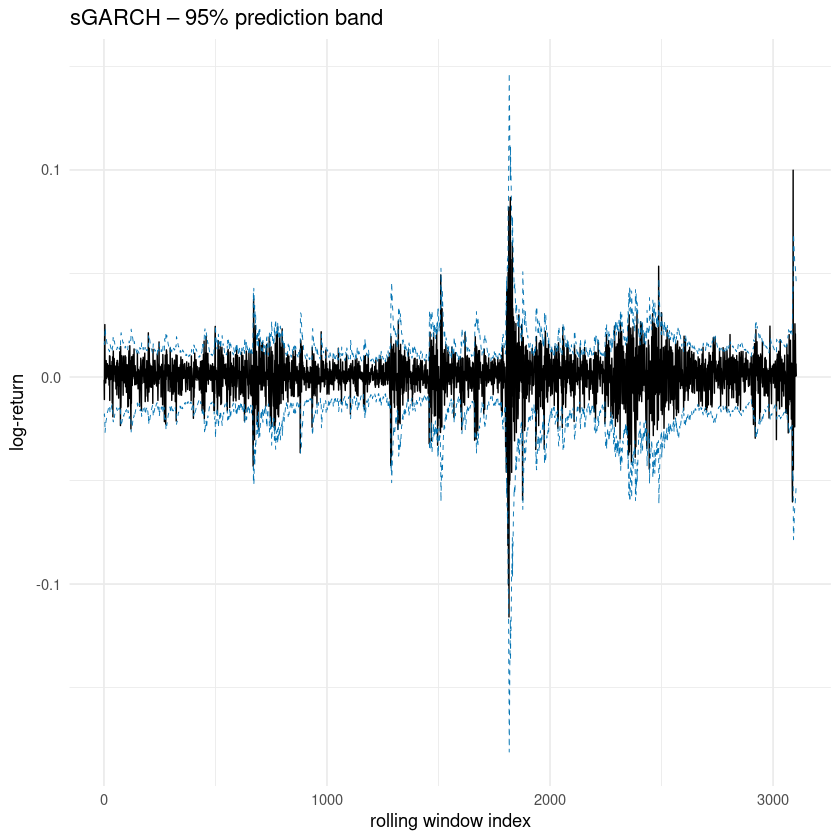

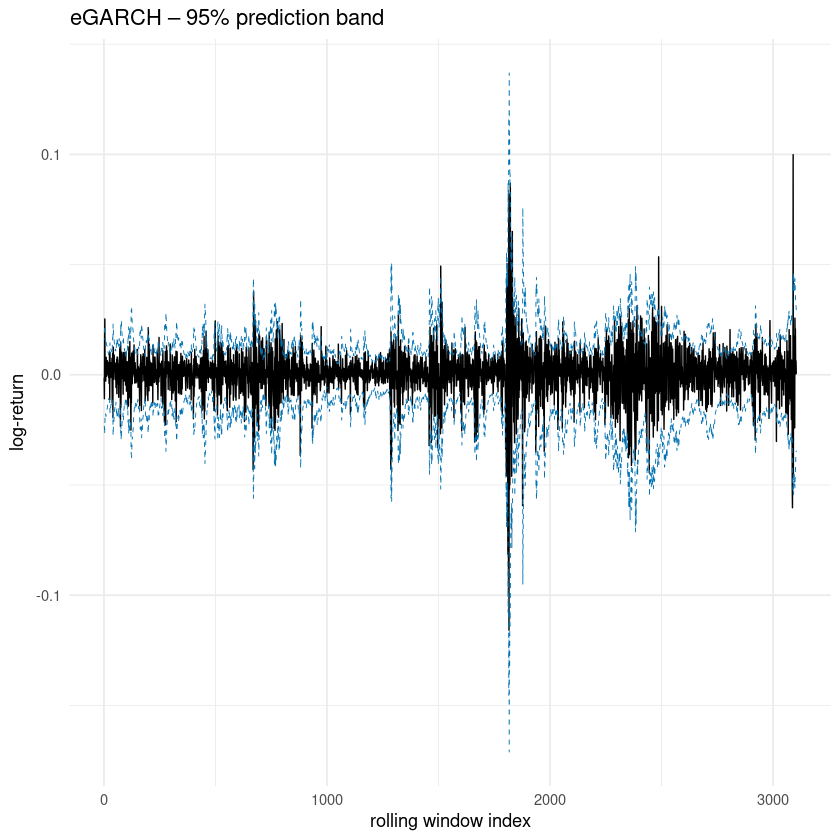

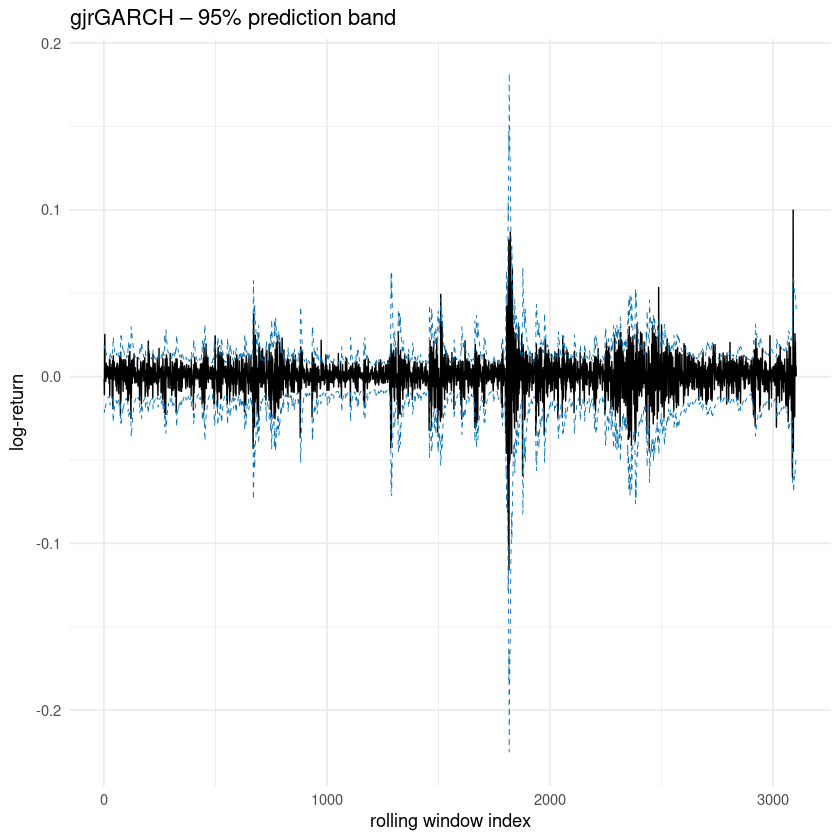

In [ ]:
library(ggplot2)
library(data.table)

#dataframe creation
plot_df <- data.table(
  date   = seq_along(real),
  real   = real,
  low_s  = low [,1], high_s = high[,1],
  low_e  = low [,2], high_e = high[,2],
  low_g  = low [,3], high_g = high[,3]
)

long <- melt(
  plot_df,
  id.vars = c("date","real"),
  measure.vars = list(
    low  = grep("^low_",  names(plot_df), value = TRUE),
    high = grep("^high_", names(plot_df), value = TRUE)
  ),
  variable.name = "model",
  value.name    = c("low","high")
)

long[, model := factor(model,
                       levels = 1:3,
                       labels = c("sGARCH","eGARCH","gjrGARCH"))]

## wrap function to plot
one_plot <- function(mod){
  L <- long[model == mod]
  lower <- L[, .(date, value = low )]
  upper <- L[, .(date, value = high)]

  ggplot() +
    geom_line(data = plot_df[!is.na(real)],
              aes(x = date, y = real),
              colour = "black", linewidth = 0.4) +
    geom_line(data = lower,
              aes(x = date, y = value),
              colour = "#0072B2", linetype = "dashed", linewidth = 0.25) +
    geom_line(data = upper,
              aes(x = date, y = value),
              colour = "#0072B2", linetype = "dashed", linewidth = 0.25) +
    labs(title = sprintf("%s – 95%% prediction band", mod),
         x = "rolling window index",
         y = "log-return") +
    theme_minimal()
}

p_s  <- one_plot("sGARCH")
p_e  <- one_plot("eGARCH")
p_g  <- one_plot("gjrGARCH")

## print plots
print(p_s)
print(p_e)
print(p_g)


Da questi plot possiamo ottenere un risultato qualitativo dell'efficacia del modello. Notiamo infatti come nei periodi in cui la volatilita' resta alta, le bande di previsione si adattino in maniera efficace a questo comportamento.